In [55]:
import pandas as pd
import numpy as np
import ampal
from dp_utils.pipeline_data import get_full_pipeline_df
from utils import useful_cols,useful_cols_non_csv
import pandas

pandas.set_option("display.max_rows", None, "display.max_columns", None)

def classify_and_sum_compositions(df):
    # Define amino acid groups
    hydrophobic = {"PHE", "TRP", "GLY", "ALA", "VAL", "LEU", "ILE", "MET", "CYS", "PRO"}
    polar = {"TYR", "THR", "SER", "ASN", "GLN"}
    charged = {"ASP", "GLU", "LYS", "ARG", "HIS"}

    # Get all composition columns in the DataFrame
    composition_cols = [col for col in df.columns if col.startswith("composition_")]

    # Helper to match by AA name
    def filter_cols(aa_set):
        return [col for col in composition_cols if col.split("_")[1] in aa_set]

    # Get categorized column lists
    hydro_cols = filter_cols(hydrophobic)
    polar_cols = filter_cols(polar)
    charged_cols = filter_cols(charged)

    # Add summed composition columns to df
    df["composition_hydrophobic"] = df[hydro_cols].sum(axis=1)
    df["composition_polar"] = df[polar_cols].sum(axis=1)
    df["composition_charged"] = df[charged_cols].sum(axis=1)

    return df


In [56]:
df =pd.read_pickle("/home/tadas/code/deltaproteinsBristol/deltaprot_designs_all_data_with_results.pkl")

## Oligo search for the his-tagged proteins
##### Problems
- Monomer properties are lower than w/o his tag


This data is not saved anywhere as the results are not very clear and experiment confusing. Need controls on the his tag

In [4]:

# write fasta file with Name and sequence for oligo search experiment

oligomeric_states = [1,2,3,4]
seeds_per_oligomeric_state = 5
df_tested = df[df.transformation_attempted==True]

with open("oligo_search.fasta", "w") as f:
    for name, sequence in zip(df_tested.Name, df_tested.model_sequence_w_prefix):
        for oligomeric_state in oligomeric_states:
            # for seed in range(seeds_per_oligomeric_state):
            # sequence:sequence:sequence for oligomeric state = 3 sepparated by colons
            delimiter=":"
            oligomeric_sequence = delimiter.join([sequence] * oligomeric_state)
            f.write(f">{name}_og{oligomeric_state}\n{oligomeric_sequence}\n")
# colabfold_batch \
#     /home/tadas/code/bristol_af2_oligosearc_experiment/oligo_search.fasta /home/tadas/code/bristol_af2_oligosearc_experiment/outputs \
#     --num-seeds 1 \
#     --num-models 1 \
#     --num-recycle 0 
with open("run_colabfold.sh", "w") as f:
    f.write(f"colabfold_batch /home/tadas/code/bristol_af2_oligosearc_experiment/oligo_search.fasta /home/tadas/code/bristol_af2_oligosearc_experiment/outputs --num-seeds {seeds_per_oligomeric_state} --num-models 1 --num-recycle 0")

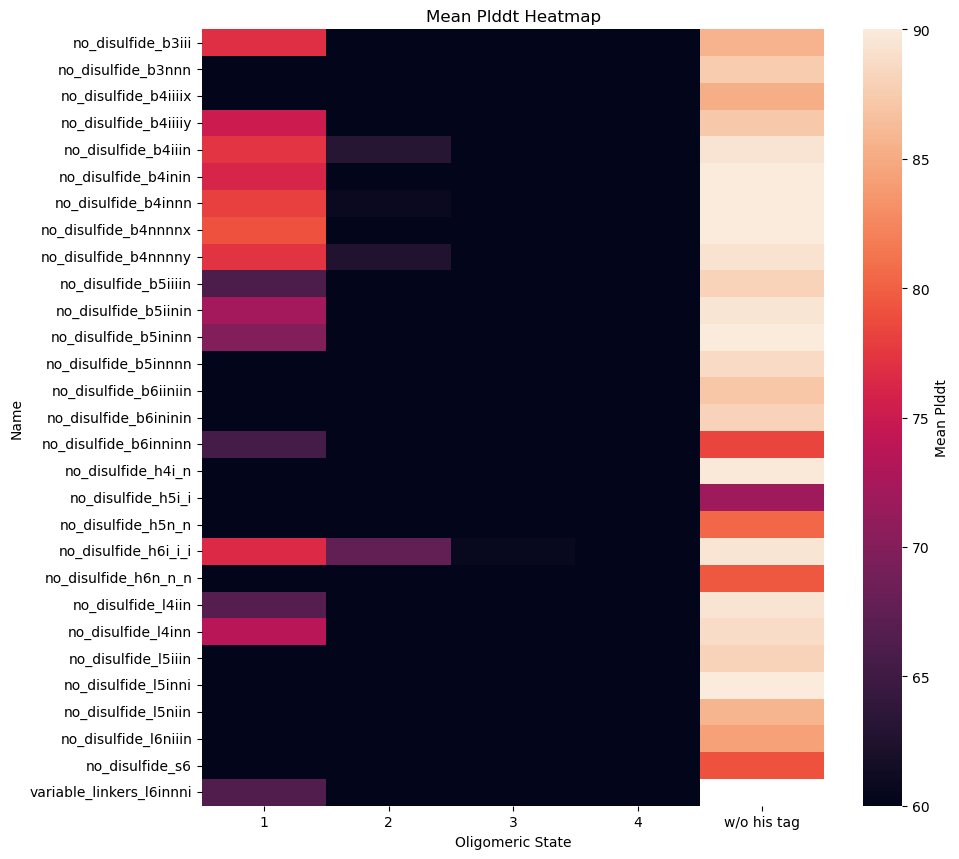

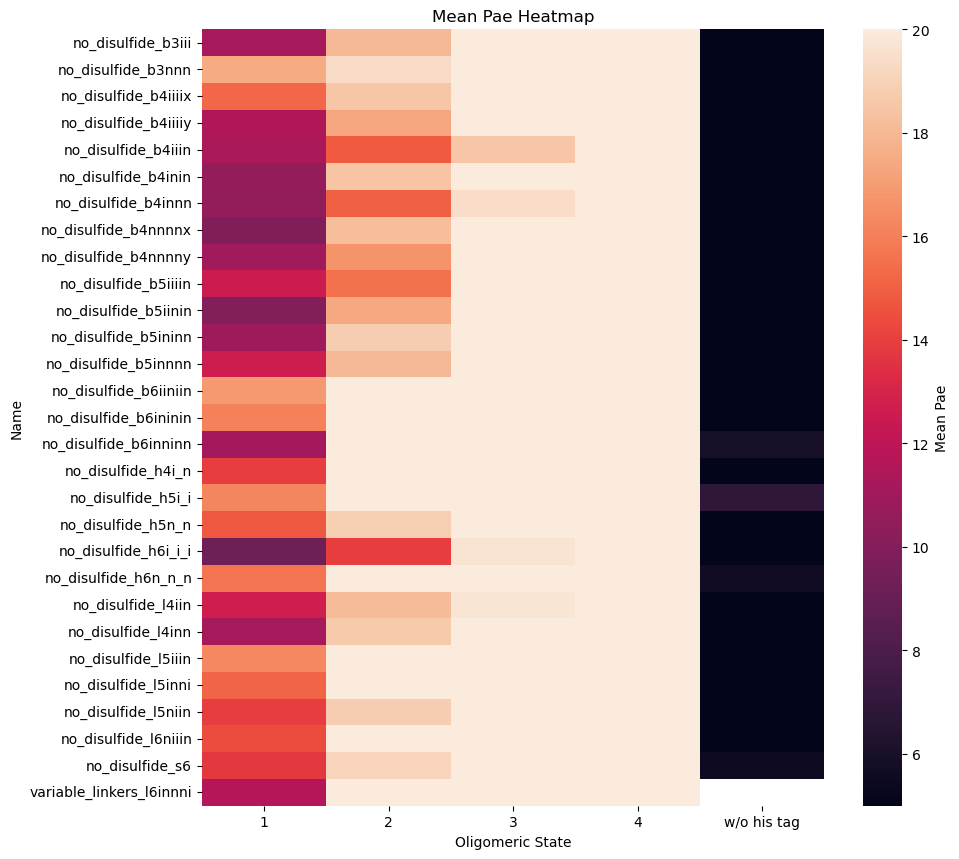

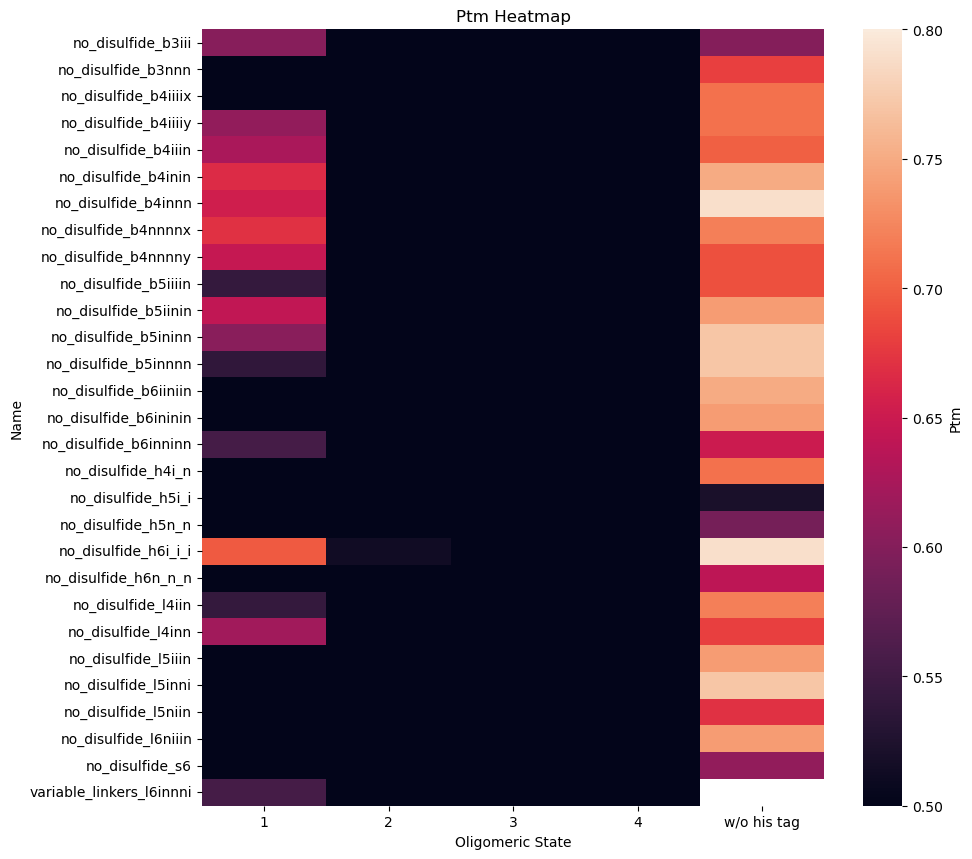

In [67]:
from tkinter import font
from dp_utils.functions import get_af2_prediction_scores_from_json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re
import json

# Regex to capture name, oligomeric_state, and seed
PAT = re.compile(
    r"""
    ^(?P<name>.+?)            # minimal up to '_og'
    _og(?P<oligomeric_state>\d+)
    .*?                       # skip intermediate text
    _seed_(?P<seed>\d+)
    \.json$
    """,
    re.VERBOSE,
)

def parse_filename(path: Path):
    m = PAT.match(path.name)
    if not m:
        return None
    info = m.groupdict()
    info["oligomeric_state"] = int(info["oligomeric_state"])
    return info

# Aggregate data
data = []
out_dir = Path("/home/tadas/code/deltaproteinsBristol/bristol_af2_oligosearc_experiment/outputs")
for p in out_dir.glob("*scores_rank*.json"):
    info = parse_filename(p)
    if not info:
        continue
    mean_plddt,mean_pae,ptm = get_af2_prediction_scores_from_json(p)
    data.append({
        "name": info["name"],
        "oligomeric_state": info["oligomeric_state"],
        "mean_plddt": mean_plddt,
        "mean_pae": mean_pae,
        "ptm": ptm,
        "seed": int(info["seed"]),
    })

# Create DataFrame
oligo_search_df = pd.DataFrame(data)

# Aggregate by name & oligomeric_state
agg = (
    oligo_search_df
    .groupby(['name', 'oligomeric_state'])
    .agg({
        'mean_plddt': 'mean',
        'mean_pae': 'mean',
        'ptm': 'mean'
    })
    .reset_index()
)
# concat df[["name","mean_pae", "mean_plddt", "ptm"]] into agg and give it oligomeric state = "w/o his tag"
wo_his_tag_df = df[df.transformation_attempted==True][["name","mean_pae", "mean_plddt", "ptm"]]
wo_his_tag_df["oligomeric_state"] = "w/o his tag"
agg = pd.concat([agg, wo_his_tag_df], ignore_index=True)
import matplotlib.pyplot as plt
import seaborn as sns

# after you’ve built `agg` (averaged per name & state)...

# 1) define your ranges
range_map = {
    'mean_plddt': (60, 90),
    'mean_pae':  ( 5, 20),
    'ptm':       (0.5, 0.8),
}

metrics = ['mean_plddt', 'mean_pae', 'ptm']

for metric in metrics:
    pivot = agg.pivot(index='name', columns='oligomeric_state', values=metric)
    vmin, vmax = range_map[metric]
    
    plt.figure(figsize=(10, max(4, 0.3 * len(pivot))))
    sns.heatmap(
        pivot,
        cmap="rocket",
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': metric.replace('_', ' ').title()},
        
        # linewidths=0.5,
        # linecolor='white'
    )
    plt.title(f"{metric.replace('_', ' ').title()} Heatmap")
    plt.xlabel("Oligomeric State")
    plt.ylabel("Name")
    plt.tight_layout()
    plt.show()

### Looking for patterns in expression

In [5]:
df = classify_and_sum_compositions(df)

/tmp/ipykernel_3949/667709211.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["composition_hydrophobic"] = df[hydro_cols].sum(axis=1)
/tmp/ipykernel_3949/667709211.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["composition_polar"] = df[polar_cols].sum(axis=1)
/tmp/ipykernel_3949/667709211.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

dp_finder_total_cost


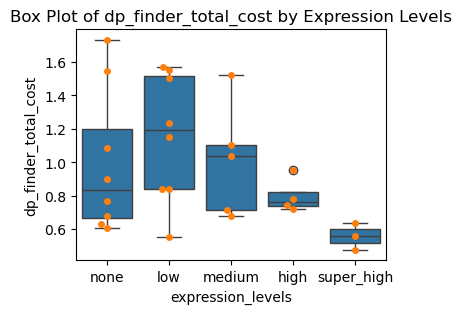

atp_cost_per_aa


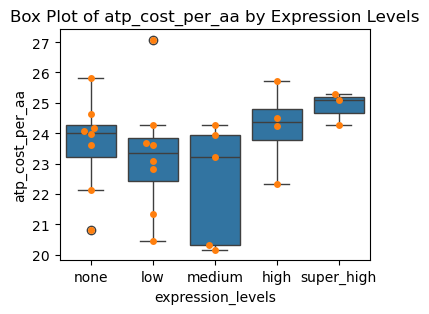

sequence_length


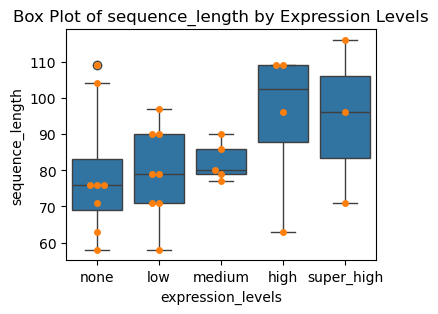

dna_complexity_per_aa


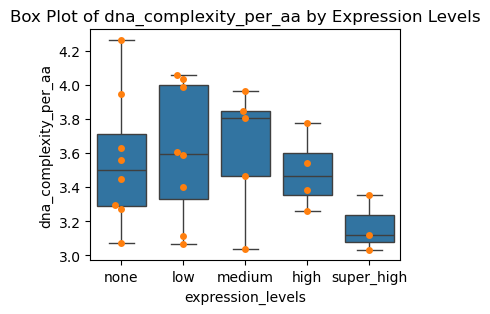

sequence_molar_extinction_280


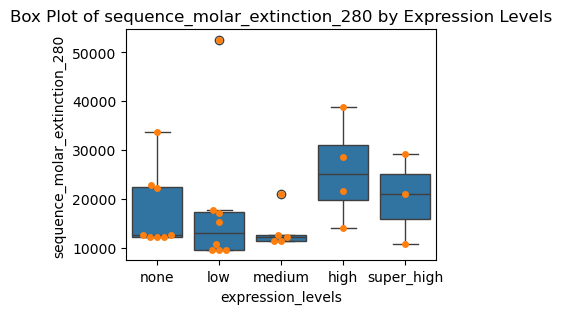

pll_per_aa


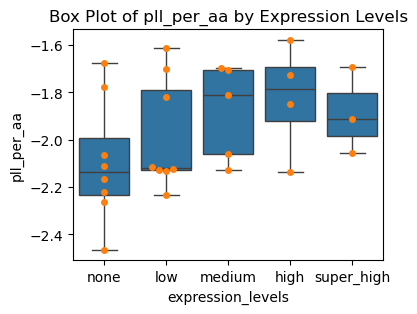

mean_pae


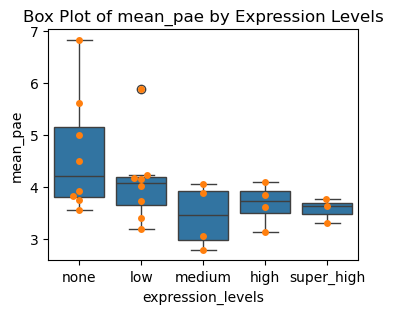

mean_plddt


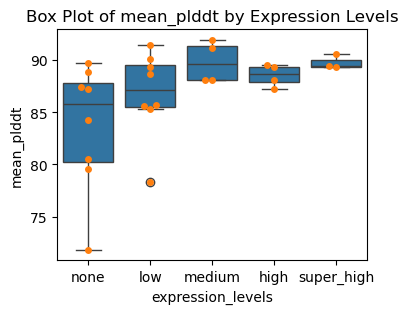

ptm


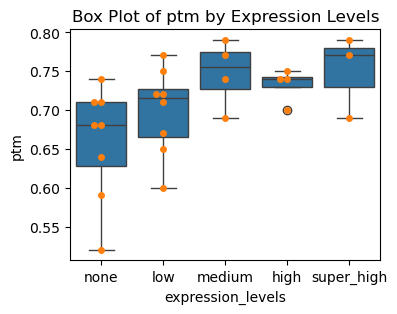

aggrescan3d_avg_value


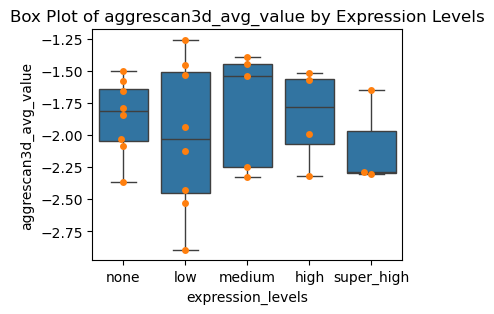

hydrophobic_fitness


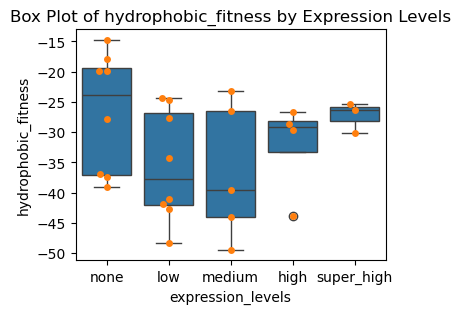

packing_density


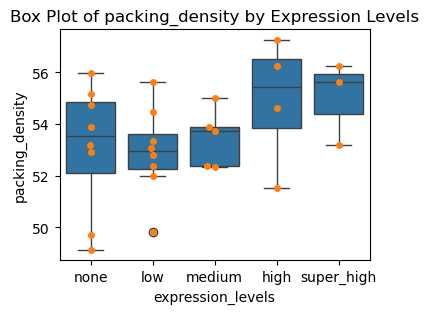

rosetta_total_per_aa


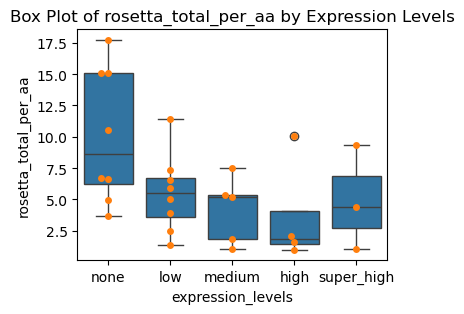

predicted_usability


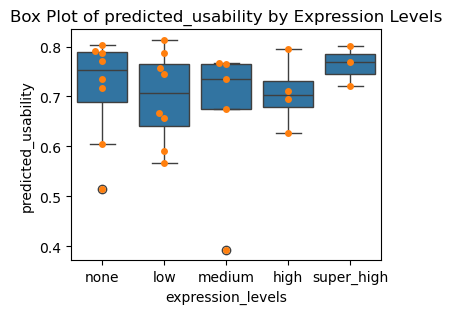

In [6]:
from math import nan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it includes a categorical 'expression_levels'
# Identify all numeric columns in the dataframe

numeric_columns = df[["composition_hydrophobic","composition_polar","composition_charged"]+useful_cols].select_dtypes(include=[np.number]).columns.tolist()
numeric_columns =['dp_finder_total_cost',
 'atp_cost_per_aa',
 'sequence_length',
 'dna_complexity_per_aa',
 'sequence_molar_extinction_280',
 'pll_per_aa',
 'mean_pae',
 'mean_plddt',
 'ptm',
 'aggrescan3d_avg_value',
 'hydrophobic_fitness',
 'packing_density',
 'rosetta_total_per_aa',
 'predicted_usability']
# 1. Box Plots for each numeric feature
for col in numeric_columns:
    print(col)
    plt.figure(figsize=(4,3))
    sns.boxplot(x='expression_levels', y=col, data=df,order=["none","low","medium","high","super_high"])
    sns.swarmplot(x='expression_levels', y=col, data=df,order=["none","low","medium","high","super_high"])
    plt.title(f'Box Plot of {col} by Expression Levels')
    plt.show()

# # 2. Violin Plots for each numeric feature
# for col in numeric_columns:
#     plt.figure(figsize=(6,4))
#     sns.violinplot(x='expression_levels', y=col, data=df)
#     plt.title(f'Violin Plot of {col} by Expression Levels')
#     plt.show()

# # 3. Scatter Plot Matrix (Pairplot)
# sns.pairplot(df, hue='expression_levels', vars=numeric_columns)
# plt.show()

# # 4. Faceted Histograms using seaborn's FacetGrid for one numeric feature example:
# g = sns.FacetGrid(df, col="expression_levels", col_wrap=4, height=3)
# g.map(plt.hist, numeric_columns[0], bins=20)
# plt.show()


/tmp/ipykernel_3949/3482114460.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['expression_rank'] = df['expression_levels'].map(expression_map)
/tmp/ipykernel_3949/3482114460.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='expression_levels', y=col, data=df, order=expression_order,
/tmp/ipykernel_3949/3482114460.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(x_labels)


--- Running Statistical Tests (low N warning) ---
Skipping stats for path_score_version due to insufficient data/variance.
Skipping stats for residues_per_helix due to insufficient data/variance.

--- Statistical Test Results (Interpret with Caution!) ---
                                     spearman_rho  spearman_p  kruskal_stat  \
feature                                                                       
composition_hydrophobic                 -0.037730    0.848829      3.330788   
composition_polar                       -0.130928    0.506634      3.327463   
composition_charged                      0.153172    0.436471      2.897044   
atp_cost_per_aa                          0.190620    0.331236      6.660591   
atp_cost                                 0.340092    0.082614      3.424603   
dna_complexity_per_aa                   -0.226942    0.245501      4.441010   
pll                                     -0.045332    0.818825      0.448153   
pll_per_aa                       

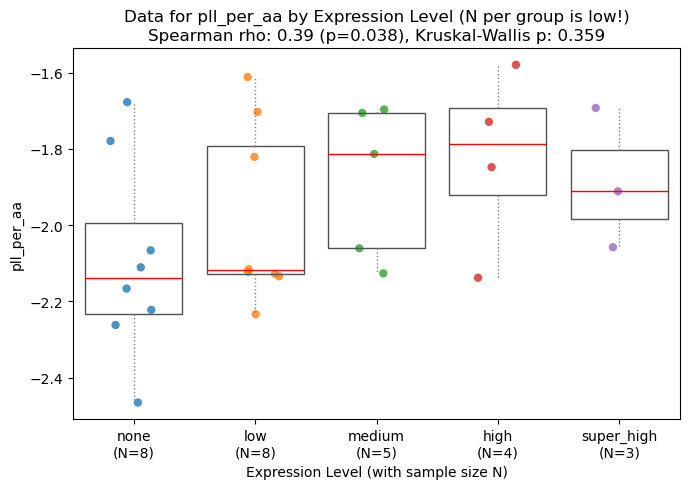

/tmp/ipykernel_3949/3482114460.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='expression_levels', y=col, data=df, order=expression_order,
/tmp/ipykernel_3949/3482114460.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(x_labels)


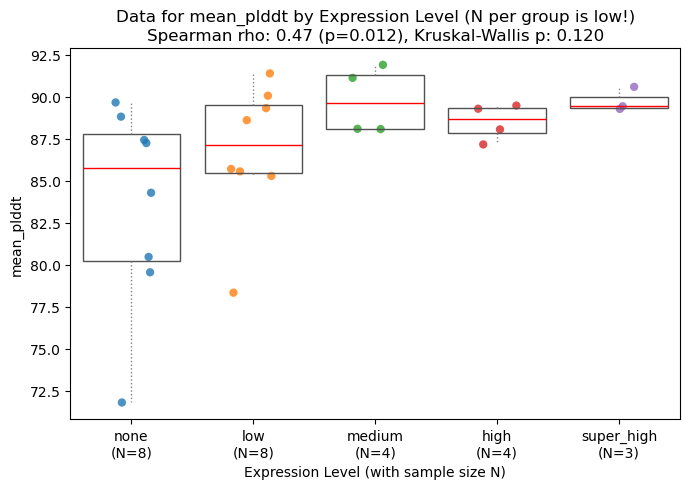

/tmp/ipykernel_3949/3482114460.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='expression_levels', y=col, data=df, order=expression_order,
/tmp/ipykernel_3949/3482114460.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(x_labels)


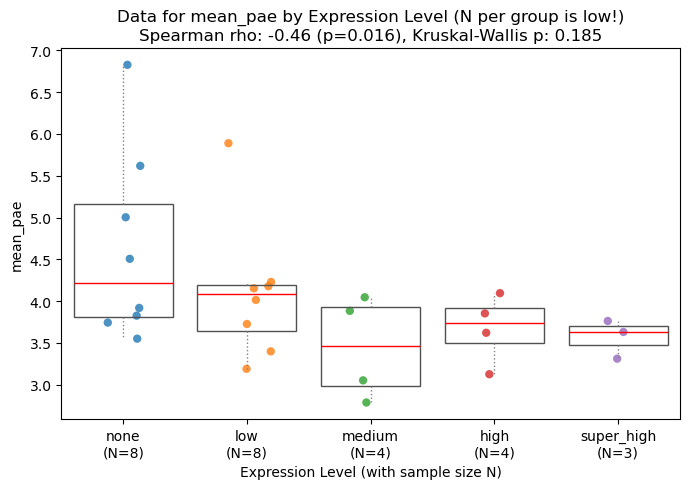

/tmp/ipykernel_3949/3482114460.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='expression_levels', y=col, data=df, order=expression_order,
/tmp/ipykernel_3949/3482114460.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(x_labels)


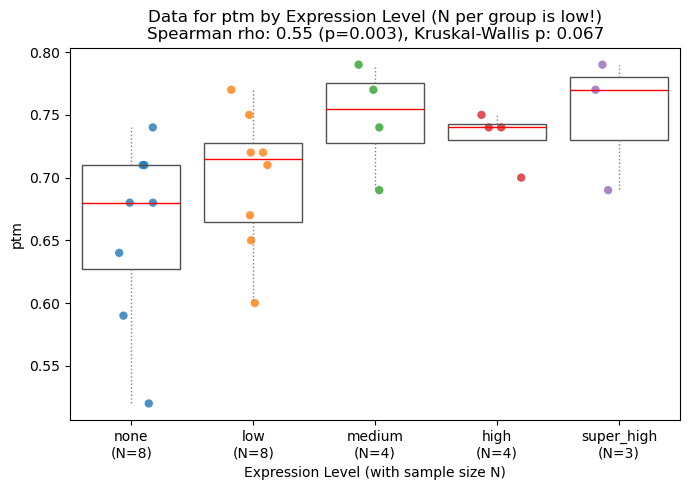

/tmp/ipykernel_3949/3482114460.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='expression_levels', y=col, data=df, order=expression_order,
/tmp/ipykernel_3949/3482114460.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(x_labels)


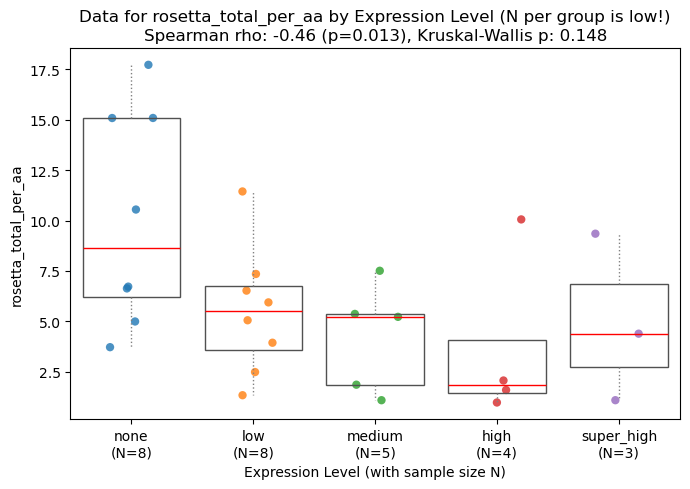

/tmp/ipykernel_3949/3482114460.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='expression_levels', y=col, data=df, order=expression_order,
/tmp/ipykernel_3949/3482114460.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(x_labels)


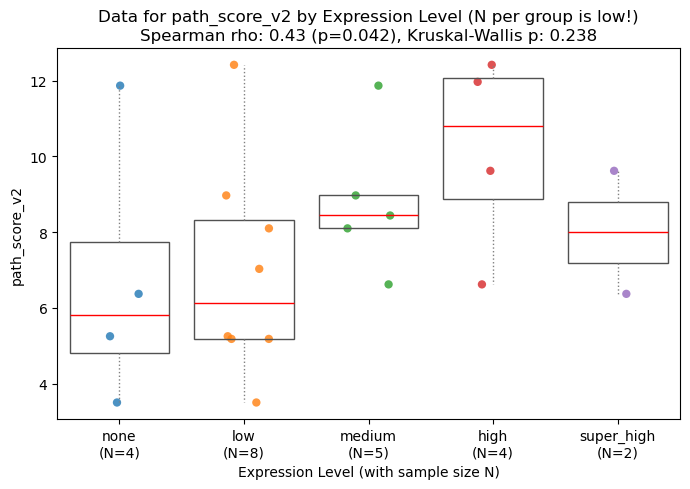

/tmp/ipykernel_3949/3482114460.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='expression_levels', y=col, data=df, order=expression_order,
/tmp/ipykernel_3949/3482114460.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(x_labels)


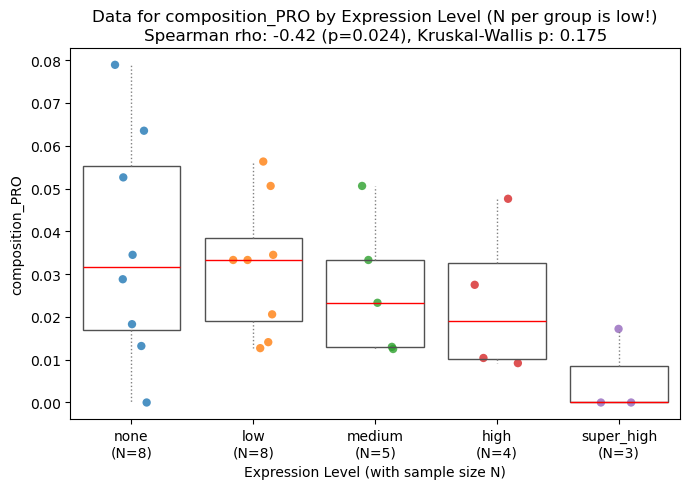


--- Visualization: Heatmaps (Significant Features - Interpret Cautiously) ---


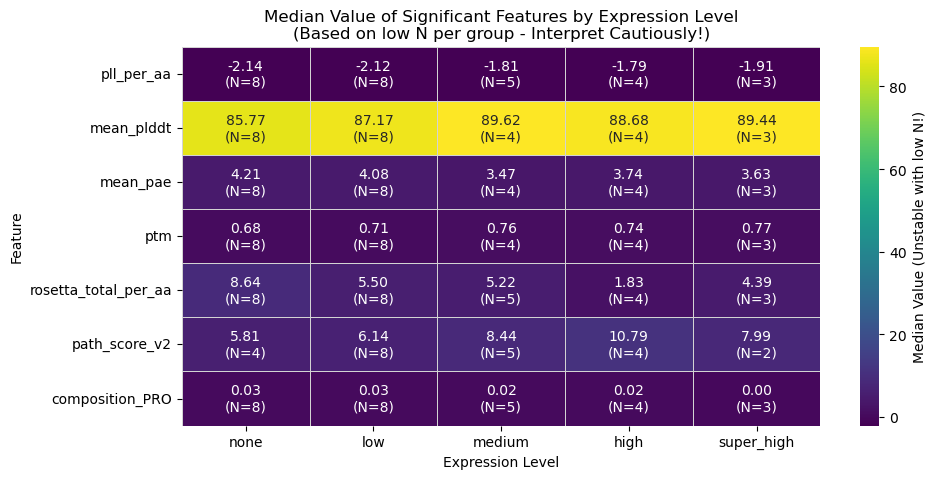

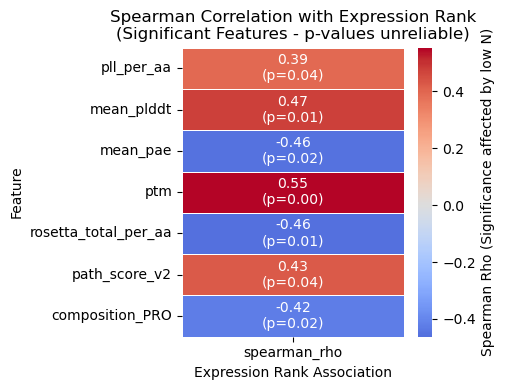

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kruskal
import scikit_posthocs as sp # Optional for post-hoc

# --- Configuration ---
# Significance level (interpret cautiously with low N)
alpha = 0.05
# Minimum absolute Spearman rho (interpret cautiously with low N)
min_rho_threshold = 0.3 # Maybe lower this slightly if expecting only weak trends? e.g. 0.25
# Order of expression levels
expression_order = ["none", "low", "medium", "high", "super_high"]
# Plotting settings
individual_plot_figsize = (7, 5)
point_size = 6 # Make points slightly larger for visibility
point_alpha = 0.8

# --- Load/Prepare Data (Assuming df exists) ---
# ... (same as before: load df, ensure expression_levels is ordered categorical) ...
# Example DataFrame setup (replace with your actual data loading)
# data = {
#     'composition_hydrophobic': np.concatenate([np.random.normal(1, 1, 5), np.random.normal(2, 1, 7), np.random.normal(3, 1, 10), np.random.normal(4, 1, 6), np.random.normal(5, 1, 4)]),
#     'composition_polar': np.concatenate([np.random.normal(5, 1, 5), np.random.normal(4.5, 1, 7), np.random.normal(4, 1, 10), np.random.normal(3.5, 1, 6), np.random.normal(3, 1, 4)]) + np.random.rand(32)*0.1,
#     'composition_charged': np.random.rand(32) * 5,
#     'expression_levels': np.repeat(expression_order, [5, 7, 10, 6, 4])
# }
# df = pd.DataFrame(data)
# df['expression_levels'] = pd.Categorical(df['expression_levels'], categories=expression_order, ordered=True)
# df = df.sample(frac=1).reset_index(drop=True) # Shuffle


# --- Define Columns ---
# ... (same as before: define numeric_columns) ...
numeric_columns = df[["composition_hydrophobic","composition_polar","composition_charged"] +useful_cols # Add your other useful cols here
                   ].select_dtypes(include=[np.number]).columns.tolist()


# --- Map Expression Levels to Ranks ---
expression_map = {level: i for i, level in enumerate(expression_order)}
df['expression_rank'] = df['expression_levels'].map(expression_map)

# --- Perform Statistical Tests (Add checks for group size) ---
print("--- Running Statistical Tests (low N warning) ---")
results = []
min_group_size_threshold = 3 # Minimum required samples in a group for reliable-ish stats

for col in numeric_columns:
    # Check overall variance
    valid_data = df[[col, 'expression_rank']].dropna()
    if valid_data.empty or valid_data[col].nunique() <= 1 or valid_data['expression_rank'].nunique() <= 1:
         rho, p_spearman = np.nan, 1.0
         kw_stat, p_kruskal = np.nan, 1.0
         print(f"Skipping stats for {col} due to insufficient data/variance.")
         too_sparse = True
    else:
        # Spearman Correlation
        rho, p_spearman = spearmanr(valid_data[col], valid_data['expression_rank'])

        # Kruskal-Wallis Test
        groups = []
        group_sizes = []
        too_sparse = False
        for level in expression_order:
            group_data = df[col][df['expression_levels'] == level].dropna().values
            groups.append(group_data)
            group_sizes.append(len(group_data))
            if 0 < len(group_data) < min_group_size_threshold:
                 too_sparse = True # Flag if any non-empty group is too small

        if too_sparse:
            print(f"Warning: Feature '{col}' has groups with < {min_group_size_threshold} samples ({group_sizes}). Kruskal-Wallis results may be unreliable.")

        # Filter out empty groups before passing to kruskal
        groups_non_empty = [g for g in groups if len(g) > 0]
        if len(groups_non_empty) > 1:
            try:
                kw_stat, p_kruskal = kruskal(*groups_non_empty)
            except ValueError as e:
                print(f"Could not run Kruskal-Wallis for {col}: {e}")
                kw_stat, p_kruskal = np.nan, 1.0
        else:
             kw_stat, p_kruskal = np.nan, 1.0 # Not enough groups

    results.append({
        'feature': col,
        'spearman_rho': rho,
        'spearman_p': p_spearman,
        'kruskal_stat': kw_stat,
        'kruskal_p': p_kruskal,
        'min_group_size': min([s for s in group_sizes if s > 0] + [0]), # Track min size of non-empty groups
        'sparse_warning': too_sparse
    })

results_df = pd.DataFrame(results).set_index('feature')
print("\n--- Statistical Test Results (Interpret with Caution!) ---")
print(results_df)


# --- Identify Significant Features (using the same criteria, but results are less reliable) ---
significant_features_df = results_df[
    ((results_df['kruskal_p'] < alpha) & ~results_df['sparse_warning']) | # Require KW significance AND no sparsity warning
    ((results_df['spearman_p'] < alpha) & (results_df['spearman_rho'].abs() > min_rho_threshold))
]
# Note: The KW part now also checks the sparse_warning flag. You might adjust this logic.

significant_feature_names = significant_features_df.index.tolist()

print(f"\n--- Identified {len(significant_feature_names)} features meeting criteria (alpha={alpha}, |rho|>{min_rho_threshold}, KW requires min N) ---")
if not significant_feature_names:
    print("No features met the significance criteria.")
    print("NOTE: With sparse data (3-10 points/group), statistical power is low. Lack of significance doesn't rule out a trend.")
    print("Consider visually inspecting plots for all features or relaxing criteria if exploring preliminary trends.")
else:
    print(significant_features_df)

    # --- Plotting Only Significant Features (Using Strip Plot + optional Box) ---
    print("\n--- Generating Plots for Significant Features (Focus on Raw Data) ---")
    for col in significant_feature_names:
        plt.figure(figsize=individual_plot_figsize)

        # Primarily use Strip plot to show all individual points
        sns.stripplot(x='expression_levels', y=col, data=df, order=expression_order,
                      jitter=0.2, # Adjust jitter amount
                      size=point_size, alpha=point_alpha, palette="tab10") # Use a palette

        # Optional: Overlay a simplified box plot (no outliers shown by default with stripplot)
        sns.boxplot(x='expression_levels', y=col, data=df, order=expression_order,
                    showfliers=False, # Don't show boxplot outliers, points are already plotted
                    showcaps=False, # Hide whisker caps for cleaner look
                    boxprops={'facecolor':'None', "zorder":10}, # Make box transparent
                    whiskerprops={'color':'gray', "zorder":10, 'linestyle':':'},
                    medianprops={'color':'red', "zorder":10}, # Highlight median
                    saturation=0.5) # Less intense colors


        rho_val = significant_features_df.loc[col, 'spearman_rho']
        kw_p_val = significant_features_df.loc[col, 'kruskal_p']
        pval_text_kw = f"{kw_p_val:.3f}" if pd.notna(kw_p_val) else "N/A"
        pval_text_sp = f"{significant_features_df.loc[col, 'spearman_p']:.3f}" if pd.notna(significant_features_df.loc[col, 'spearman_p']) else "N/A"

        plot_title = (f'Data for {col} by Expression Level (N per group is low!)\n'
                      f'Spearman rho: {rho_val:.2f} (p={pval_text_sp}), Kruskal-Wallis p: {pval_text_kw}')

        # Add N counts to x-axis labels
        n_counts = df.groupby('expression_levels')[col].count().reindex(expression_order).fillna(0).astype(int)
        x_labels = [f"{level}\n(N={n_counts[level]})" for level in expression_order]
        plt.gca().set_xticklabels(x_labels)

        plt.title(plot_title)
        plt.xlabel("Expression Level (with sample size N)")
        plt.ylabel(col)
        # plt.xticks(rotation=0) # No rotation usually needed if labels are short
        plt.tight_layout()
        plt.show()

    # --- Optional: Post-hoc tests (EXTREMELY unreliable with N=3-10 per group) ---
    # Generally NOT recommended to interpret post-hoc p-values here. Visual inspection is better.
    # If you run them, add very strong caveats.
    # ... (post-hoc code could go here, but with warnings) ...

    # --- Focused Heatmaps (Significant Features Only - Interpret medians/correlations cautiously) ---
    print("\n--- Visualization: Heatmaps (Significant Features - Interpret Cautiously) ---")

    # 1. Heatmap of Median Values
    if not significant_features_df.empty:
        median_table = df.groupby('expression_levels')[numeric_columns].median().reindex(expression_order)
        median_table_significant = median_table[significant_feature_names]

        # Add N counts to the heatmap annotation
        n_counts_table = df.groupby('expression_levels')[significant_feature_names].count().reindex(expression_order).fillna(0).astype(int)
        annot_labels = median_table_significant.applymap(lambda x: f"{x:.2f}" if pd.notna(x) else "NaN") + \
                       "\n(N=" + n_counts_table.astype(str) + ")"


        plt.figure(figsize=(10, max(4, len(significant_feature_names) * 0.7)))
        sns.heatmap(median_table_significant.T, annot=annot_labels.T, cmap="viridis", fmt="", # Use custom annotations
                    linewidths=.5, linecolor='lightgray', cbar_kws={'label': 'Median Value (Unstable with low N!)'})
        plt.title('Median Value of Significant Features by Expression Level\n(Based on low N per group - Interpret Cautiously!)')
        plt.xlabel("Expression Level")
        plt.ylabel("Feature")
        plt.yticks(rotation=0)
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping median heatmap.")

    # 2. Heatmap of Spearman Correlations
    if not significant_features_df.empty:
        spearman_corr_significant = results_df.loc[significant_feature_names, ['spearman_rho', 'spearman_p']] # Include p-value for context

        annot_labels_corr = spearman_corr_significant.apply(lambda x: f"{x['spearman_rho']:.2f}\n(p={x['spearman_p']:.2f})", axis=1)


        plt.figure(figsize=(5, max(4, len(significant_feature_names) * 0.5)))
        sns.heatmap(spearman_corr_significant[['spearman_rho']], annot=annot_labels_corr.to_frame(name='label'), # Use custom annotations in a frame
                    fmt="", cmap="coolwarm", center=0, linewidths=.5,
                    cbar_kws={'label': 'Spearman Rho (Significance affected by low N)'})
        plt.title('Spearman Correlation with Expression Rank\n(Significant Features - p-values unreliable)')
        plt.ylabel("Feature")
        plt.xlabel("Expression Rank Association")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
         print("Skipping correlation heatmap.")